# Transfer Learning

* Using VGGNet as a fixed feature extractor
* Code shows how to train a simple classifier for the final fully-connected layers

# Collecting the Flower Data

In [1]:
!curl -C - "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip" --output flower-photos.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  219M  100  219M    0     0  14.0M      0  0:00:15  0:00:15 --:--:-- 16.0M


In [0]:
!unzip flower-photos.zip

# Imports

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, models, transforms

%matplotlib inline

In [4]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Cuda is NOT available. Training on CPU....')
else:
    print('Cuda is available. Yay! Training on GPU....')

Cuda is available. Yay! Training on GPU....


In [0]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Transforming the Data

When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects 224-dim square images as input and so, we resize each flower image to fit this mold.

In [40]:
# load and tranform data using ImageFolder

# VGG-16 takes 224x224 images as input
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transform = transforms.Compose(
    [transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), 
     transforms.ToTensor(), normalize]
)

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

print("# training images: {}".format(len(train_data)))
print("# test images: {}".format(len(test_data)))

# training images: 3130
# test images: 540


In [0]:
# define dataloader parameters
batch_size = 20
num_workers = 4

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, num_workers=num_workers,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, num_workers=num_workers,
                                           shuffle=False)

# Visualizing Sample Data

In [0]:
dataiter = iter(train_loader)

images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for index in np.arange(20):
    ax = fig.add_subplot(2, 20/2, index+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[index], (1,2,0)))
    ax.set_title(classes[labels[index]])

# Define the model

In [49]:
# load pre-trained model

#model = models.vgg16(pretrained=True)
model = models.resnet18(pretrained=True)

# print model structure
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 75610934.78it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [53]:
print(model.fc)

TypeError: ignored

In [54]:
# FREEZE training for all "features" layers
#print(model.classifier[6].in_features)
#print(model.classifier[6].out_features)

for param in model.parameters():
    param.requires_grad = False

Linear(in_features=512, out_features=1000, bias=True)


# Final Classifier Layer

In [55]:
import torch.nn as nn

# 5 flower classes
# new layers automatically have requires_grad = True

n_inputs = model.fc.in_features

last_layer = nn.Linear(n_inputs, len(classes))

model.fc = last_layer

print(model.fc.out_features)

5


In [0]:
if train_on_gpu:
    model.cuda()

# Loss Function and Optimizer

# Training Loop

In [58]:
from tqdm import tqdm_notebook as tqdm

# cross_entropy loss and Adam optimizer
criterion = nn.CrossEntropyLoss()

# the optimizer accepts as input only the trainable parameters 
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0005)

num_epochs = 20
model.train()
for epoch in tqdm(range(num_epochs)):

    train_loss = 0.0

    ######################
    ### train the model ##
    ######################

    for index, (data, target) in enumerate(train_loader):

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # clear the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(data)

        # batch loss
        loss = criterion(outputs, target)

        # backward pass
        loss.backward()

        # perform optimization step
        optimizer.step()

        # update training loss
        train_loss += loss.item()

        if index % 20 == 0:
            print("Epoch {} | Batch {} loss: {:.5f} |".format(epoch, index, train_loss/20))
            train_loss = 0.0

Epoch 0 | Batch 0 loss: 0.08299 |
Epoch 0 | Batch 20 loss: 1.53053 |
Epoch 0 | Batch 40 loss: 1.24657 |
Epoch 0 | Batch 60 loss: 1.06576 |
Epoch 0 | Batch 80 loss: 0.96041 |
Epoch 0 | Batch 100 loss: 0.87345 |
Epoch 0 | Batch 120 loss: 0.81650 |
Epoch 0 | Batch 140 loss: 0.74766 |
Epoch 1 | Batch 0 loss: 0.02621 |
Epoch 1 | Batch 20 loss: 0.67114 |
Epoch 1 | Batch 40 loss: 0.68777 |
Epoch 1 | Batch 60 loss: 0.60450 |
Epoch 1 | Batch 80 loss: 0.61064 |
Epoch 1 | Batch 100 loss: 0.63773 |
Epoch 1 | Batch 120 loss: 0.63433 |
Epoch 1 | Batch 140 loss: 0.56229 |
Epoch 2 | Batch 0 loss: 0.02748 |
Epoch 2 | Batch 20 loss: 0.50791 |
Epoch 2 | Batch 40 loss: 0.60443 |
Epoch 2 | Batch 60 loss: 0.52608 |
Epoch 2 | Batch 80 loss: 0.52184 |
Epoch 2 | Batch 100 loss: 0.57878 |
Epoch 2 | Batch 120 loss: 0.48244 |
Epoch 2 | Batch 140 loss: 0.57240 |
Epoch 3 | Batch 0 loss: 0.01513 |
Epoch 3 | Batch 20 loss: 0.50425 |
Epoch 3 | Batch 40 loss: 0.53050 |
Epoch 3 | Batch 60 loss: 0.51273 |
Epoch 3 | Batch

In [59]:
# Testing

test_loss = 0.0
class_correct = list(0.0 for i in range(5))
class_total = list(0. for i in range(5))

model.eval()

for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    outputs = model(data)
    loss = criterion(outputs, target)

    test_loss += loss.item()*data.size(0)

    # convert output probabilities to predicted class

    _, pred = torch.max(outputs, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy() if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy()))

    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()  # Yes = +1, No=0
        class_total[label] += 1


# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test loss: {:.6f}\n'.format(test_loss)) 

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of {}: {:.2f} ({}/{})'.format(classes[i], 100* class_correct[i]/class_total[i],
                                                       np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of {}: N/A'.format(classes[i]))

print('\nTest Accuracy (Overall): {:.2f}, ({}/{})'.format(100* np.sum(class_correct)/np.sum(class_total),
                                                      np.sum(class_correct), np.sum(class_total)))

Test loss: 0.445178

Test Accuracy of daisy: 89.13 (82.0/92.0)
Test Accuracy of dandelion: 96.21 (127.0/132.0)
Test Accuracy of roses: 71.43 (65.0/91.0)
Test Accuracy of sunflowers: 87.13 (88.0/101.0)
Test Accuracy of tulips: 71.77 (89.0/124.0)

Test Accuracy (Overall): 83.52, (451.0/540.0)


# Visualize Sample Test Results with Inference

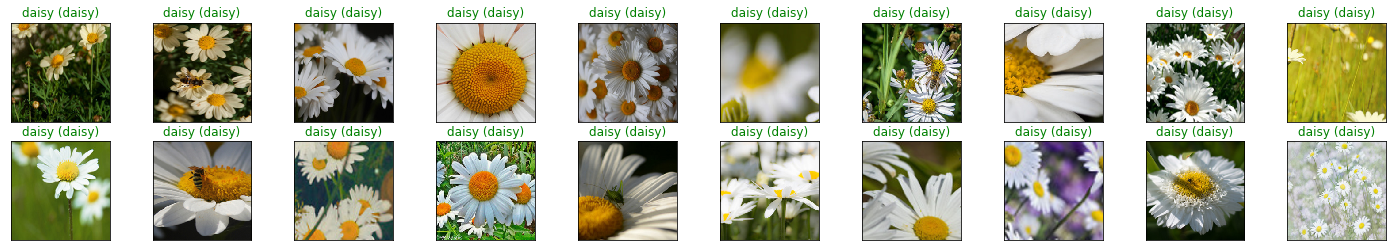

In [31]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(25,4))
images = images.cpu().numpy()

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))